In [69]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
sns.set(style='whitegrid')
import upsetplot as up

### Load and look at data

In [3]:
#Load dataframe and drop duplicate interactions based on standardized characteristics
df = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/features/features_interactions_merged_types.txt', header=0, index_col=0)
df.drop_duplicates(['EC', 'Org', 'Mode', 'ChEBI', 'Interpro_ids'], inplace=True)

#### Most frequent features

In [4]:
#Count the frequency of the features
top_features = df[['Interpro_ids', 'ENTRY_TYPE', 'ENTRY_NAME']].value_counts().to_frame().reset_index()
top_features.columns = ['Domain', 'Entry type', 'Entry name', 'Count']

In [5]:
#Look at the top 10 features
top_features.head(10)

,Domain,Entry type,Entry name,Count
0,IPR036291,Homologous_superfamily,NAD(P)-binding domain superfamily,1187
1,IPR027417,Homologous_superfamily,P-loop containing nucleoside triphosphate hydr...,822
2,IPR013785,Homologous_superfamily,Aldolase-type TIM barrel,567
3,IPR029044,Homologous_superfamily,Nucleotide-diphospho-sugar transferases,426
4,IPR015421,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, maj...",421
5,IPR015424,Homologous_superfamily,Pyridoxal phosphate-dependent transferase,420
6,IPR015422,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, sma...",377
7,IPR036188,Homologous_superfamily,FAD/NAD(P)-binding domain superfamily,293
8,IPR011009,Homologous_superfamily,Protein kinase-like domain superfamily,281
9,IPR011004,Homologous_superfamily,Trimeric LpxA-like superfamily,270


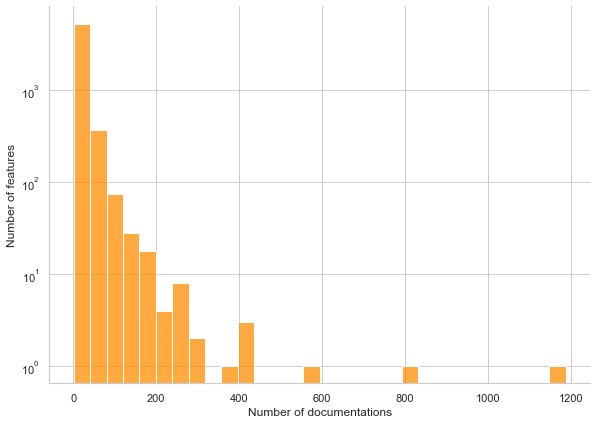

In [6]:
#Plot frequency histogram of features
ax = sns.displot(data=top_features, x='Count', kind='hist', height=6, aspect=1.4, bins=30, log_scale=[False, True], color='darkorange')
ax.set_xlabels('Number of documentations')
ax.set_ylabels('Number of features')

### Fisher's exact test

#### Prepare and perform Fisher's exact test

In [7]:
#Make dictionary of ChEBI ids and synonyms for all metabolites
#Example: CHEBI:15422: {ATP, adenosine triphosphate}
df_mets_grouped = df[['Met', 'ChEBI']].drop_duplicates().groupby(['ChEBI'])['Met'].apply(set).reset_index()
mets_dict = pd.Series(df_mets_grouped.Met.values, index=df_mets_grouped.ChEBI).to_dict()

In [8]:
#Make columns with enzyme info (EC number + organism) and interaction info (ChEBI id + mode) for Fisher's exact test
df['enzyme'] = df['EC'] + ':' + df['Org']
df['interaction'] = df['ChEBI'] + ':' + df['Mode']

In [9]:
#Make dataframe of all enzymes (EC+org) for which a feature (InterPro id) is documented
features = df.groupby('Interpro_ids').agg({'enzyme': set})

#Make dataframe of all enzymes (EC+org) for which an interaction (ChEBI+mode) is documented
interactions = df.groupby('interaction').agg({'enzyme': set})

#Make dataframe of all possible interaction-feature pairs, and sort by number of enzymes (EC+org) for which they are documented
pairs = df.groupby(['interaction', 'Interpro_ids']).agg({'enzyme': len}).sort_values('enzyme', ascending=False)

#Make a set of all enzymes (EC+org)
all_enzymes = set(df['enzyme'])

In [10]:
#Define function for performing one-sided Fisher's exact test
def calculate_fisher_one_sided(f, i):
    with_f = features.loc[f, 'enzyme']
    without_f = all_enzymes - with_f
    with_i = interactions.loc[i, 'enzyme']
    without_i = all_enzymes - with_i

    yy = len(with_f & with_i)
    yn = len(with_f & without_i)
    ny = len(without_f & with_i)
    nn = len(without_f & without_i)

    return fisher_exact([[yy, yn], [ny, nn]], alternative='greater')

In [11]:
#Perform Fisher's exact test on all interaction-feature pairs

data = []

for (i, f) in pairs.index:
    odds, p = calculate_fisher_one_sided(f, i)
    data.append([i, f, odds, p])

df_one_sided = pd.DataFrame(data, columns=['interaction', 'features', 'odds', 'p'])

#### Adjust p-value and odds ratio

In [12]:
#Do fdr correction on p-values to get adjusted p-value (q-value)
df_one_sided['is_significant'], df_one_sided['q'] = fdrcorrection(df_one_sided['p'])

In [13]:
#As the odds ratio for some associations is inifinity, this need to be adjusted for
#This codeline checks if there are any odds higher than 15 000
df_one_sided.query('odds > 15000').sort_values('odds')

,interaction,features,odds,p,is_significant,q
90,CHEBI:14336:-,IPR005999,inf,1.997106e-29,True,1.051349e-25
38854,CHEBI:16238:+,IPR009158,inf,3.109269e-03,True,1.357752e-02
38845,CHEBI:16243:-,IPR035579,inf,2.665087e-02,True,4.849938e-02
38844,CHEBI:16243:-,IPR035574,inf,2.665087e-02,True,4.849938e-02
38843,CHEBI:16243:-,IPR035572,inf,2.665087e-02,True,4.849938e-02
...,...,...,...,...,...,...
21908,CHEBI:57844:-,IPR045785,inf,1.465798e-02,True,3.362091e-02
21907,CHEBI:57844:-,IPR044639,inf,1.465798e-02,True,3.362091e-02
21902,CHEBI:57844:-,IPR042118,inf,1.465798e-02,True,3.362091e-02
21810,CHEBI:57856:-,IPR010049,inf,1.880367e-02,True,3.884533e-02


In [14]:
#Change all odds that are infinity to 15 000
df_one_sided['odds'] = df_one_sided['odds'].apply(lambda x: min(x, 15000))

In [15]:
#Make columns with log10(odds ratio) and -log10(adj. p-value) 
df_one_sided['log_o'] = np.log10(df_one_sided['odds'])
df_one_sided['log_q'] = -np.log10(df_one_sided['q'])

In [16]:
#Save all results to file
df_one_sided.to_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/fishers_test_results.txt')

### Filter for predicted interactions

In [17]:
#Make dataframe of interactions and features that are associated with q < 0.05 and log10(odds ratio) >= 1
df_predicted = df_one_sided[(df_one_sided['q'] < 0.05) & (df_one_sided['log_o'] >= 1)].drop_duplicates()

In [38]:
#Save the predicted interactions to file
df_predicted.to_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/predicted_interactions.txt')

### Classify features by name and type

In [18]:
#Get list of entry type and name for InterPro ids, downloaded from the InterPro website
df_entry_list = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/support/entry.list.txt', sep='\t', header=0)

In [19]:
#Merge dataframe of associated features and interactions with the entry-list
df_merged = pd.merge(df_one_sided, df_entry_list, left_on='features', right_on='ENTRY_AC', how='left').drop('ENTRY_AC', axis=1)

In [20]:
#Add columns for mode, ChEBI id and metabolite name 
df_merged['mode'] = df_merged['interaction'].apply(lambda x: x[-1])

df_merged['ChEBI'] = df_merged['interaction'].apply(lambda x: x[:-2])

df_merged['Met'] = df_merged['ChEBI'].map(mets_dict)

#### Separate by feature types

In [21]:
sns.set(style='white')

In [22]:
#List of all eight feature types in the data
feature_types = ['Active_site', 'Binding_site', 'Conserved_site', 'Domain', 'Family', 'Homologous_superfamily', 'PTM', 'Repeat']

In [23]:
#Make dataframes of interaction-feature associations grouped by feature type
dfs = {type:df_merged.query('ENTRY_TYPE == @type') for type in feature_types}

In [24]:
#Make dataframes of activating interaction-feature associations grouped by feature type
dfs_acts = {type:df_merged.query('ENTRY_TYPE == @type & mode == "+"') for type in feature_types}

In [25]:
#Make dataframes of inhibiting interaction-feature associations grouped by feature type
dfs_inhs = {type:df_merged.query('ENTRY_TYPE == @type & mode == "-"') for type in feature_types}

#### Make volcano plots

(-1.0, 30.0)

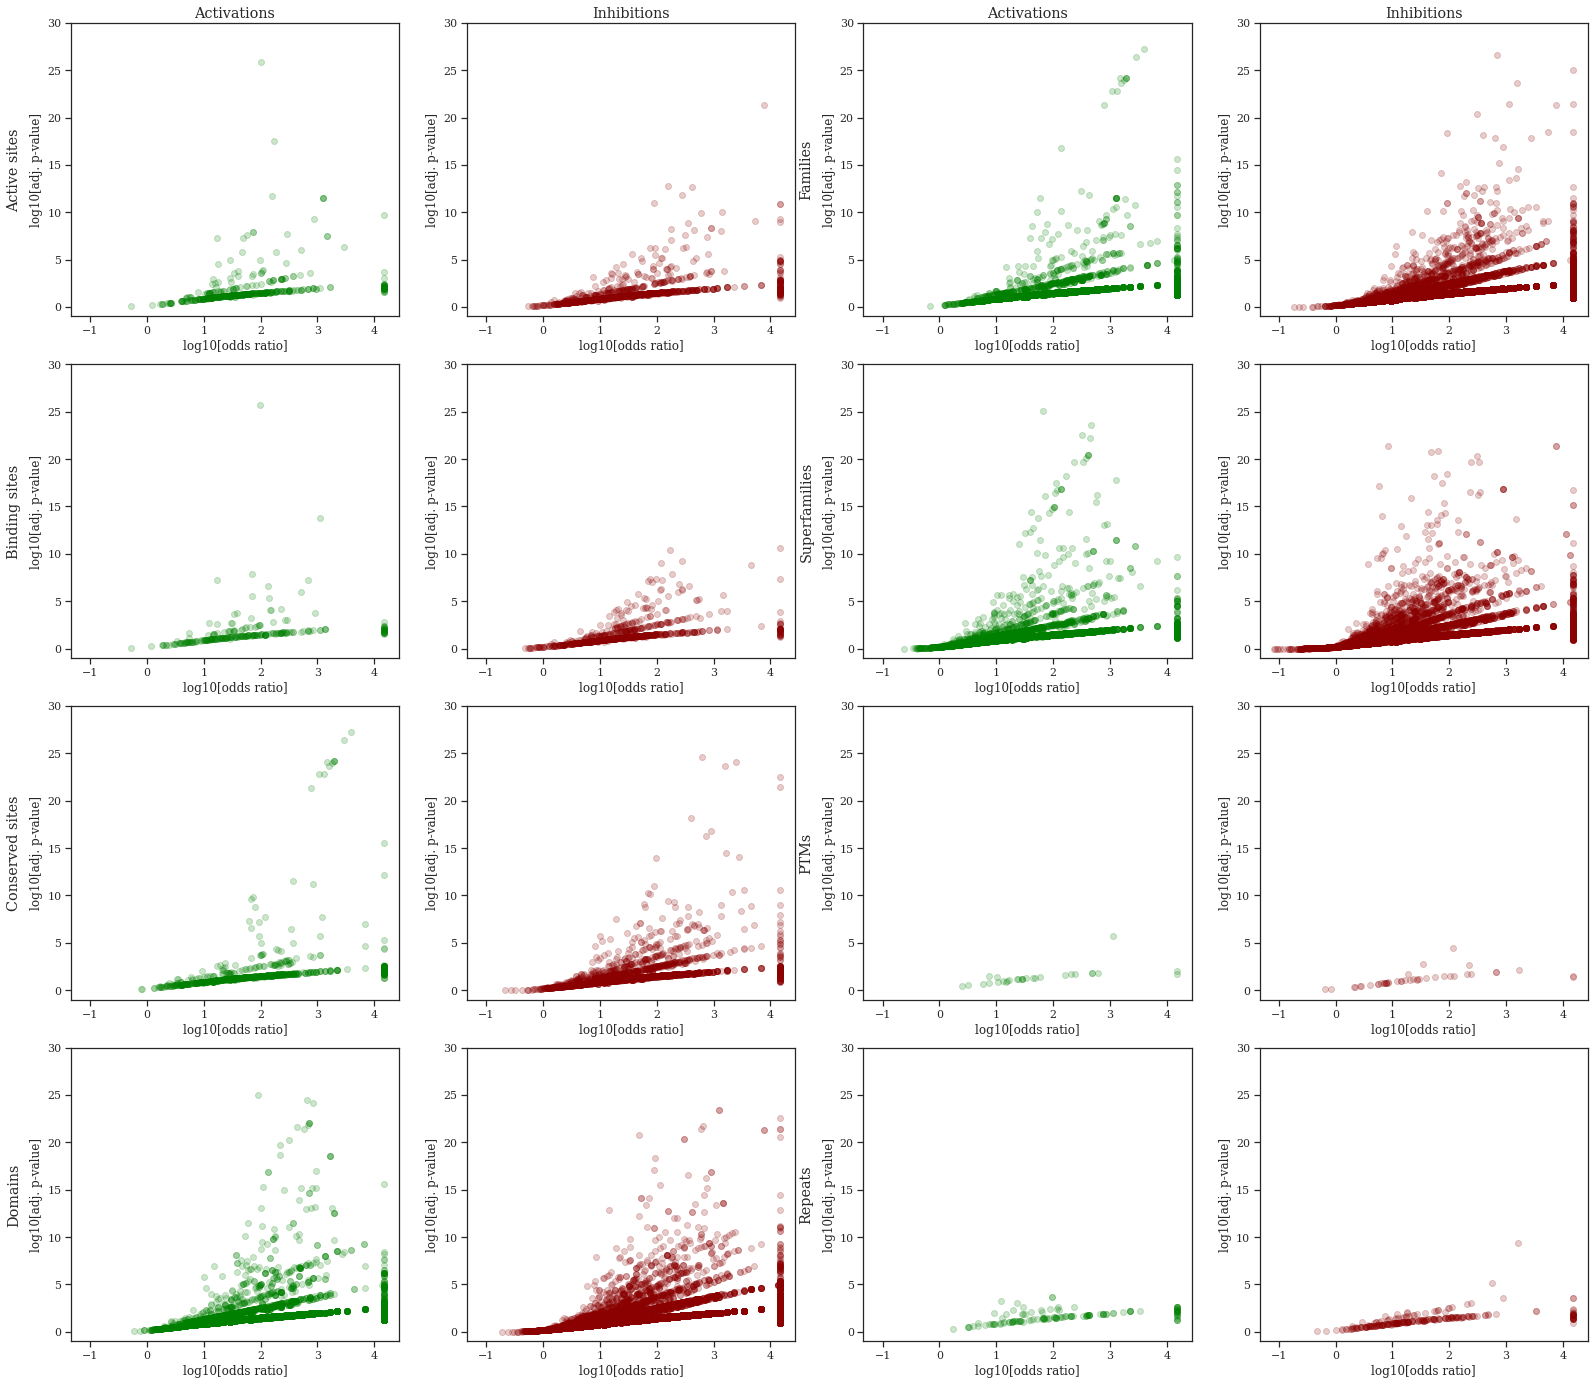

In [68]:
#Create a "superplot" of scatter plots for each feature type to evaluate which feature types has the largest effect
sns.set(style='white')
sns.set_style('ticks')
plt.rcParams["font.family"] = "serif"

cols = ['{}'.format(col) for col in ['Activations', 'Inhibitions', 'Activations', 'Inhibitions']]
rows = ['{}'.format(row) for row in ['Active sites', 'Binding sites', 'Conserved sites', 'Domains', 'Families', 'Superfamilies', 'PTMs', 'Repeats']]

fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(25,20))


pad = 5

#Set x- and y-labels for all plots
plt.setp(axes.flat, xlabel='log10[odds ratio]', ylabel='log10[adj. p-value]')

#Add headers (Activations, Inhibitions)
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#Add feature type labels
for ax, row in zip(axes[:,0], rows[:4]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

for ax, row in zip(axes[:,2], rows[4:]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


#Plot the activating interactions
r, c = 0, 0
for type in dfs_acts:
    axes[r,c].scatter(dfs_acts[type]['log_o'], dfs_acts[type]['log_q'], color='green', alpha=0.2)
    r += 1

    if r == 4:
        r, c = 0, 2

#Plot the inhibiting interactions
r, c = 0, 1
for type in dfs_inhs:
    axes[r,c].scatter(dfs_inhs[type]['log_o'], dfs_inhs[type]['log_q'], color='darkred', alpha=0.2)
    r += 1
    
    if r == 4:
        r, c = 0, 3


for ax in axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.ylim(-1,30)

#### Plot UpSet-plots

In [87]:
#Read from file of predicted interactions
# = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/predicted_interactions.txt', index_col=0)

df = pd.merge(df_predicted, df_entry_list, left_on='features', right_on='ENTRY_AC', how='left').drop('ENTRY_AC', axis=1)

#Replace _ with ' ' in feature types, and remove entries not mapped to a type
df = df.dropna()
df['ENTRY_TYPE'] = df['ENTRY_TYPE'].apply(lambda x: x.replace('_', ' '))

#Group the dataframe by interaction to get a list of feature types for every interaction
df_grouped = df.groupby('interaction')['ENTRY_TYPE'].apply(list).reset_index()
df_grouped['ENTRY_TYPE'] = df_grouped['ENTRY_TYPE'].apply(lambda x: ','.join(x))

#Get mode from interaction column and make new dataframes for activators and inhibitors
df_grouped['Mode'] = df_grouped['interaction'].apply(lambda x: x[-1])
df_acts = df_grouped.query('Mode == "+"')
df_inhs = df_grouped.query('Mode == "-"')

#Use UpSet function to create the dataframe of boolean values for making the UpSet plot (activators)
features_by_type_acts = up.from_memberships(df_acts.ENTRY_TYPE.str.split(','), data=df_acts)

#Use UpSet function to create the dataframe of boolean values for making the UpSet plot (inhibitors)
features_by_type_inhs = up.from_memberships(df_inhs.ENTRY_TYPE.str.split(','), data=df_inhs)

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

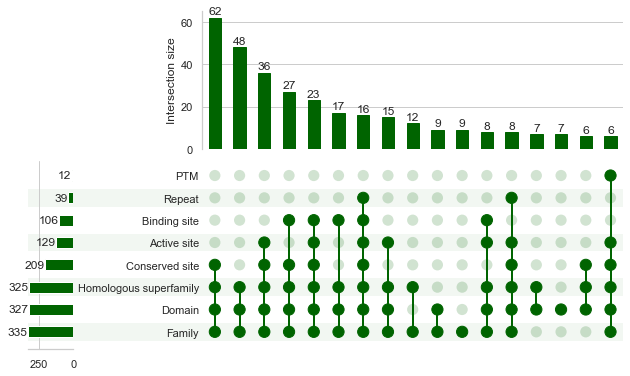

In [88]:
#Create UpSet-plot for activators
up.UpSet(features_by_type_acts, show_counts=True, sort_by='cardinality', min_subset_size=6, facecolor='darkgreen').plot()

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

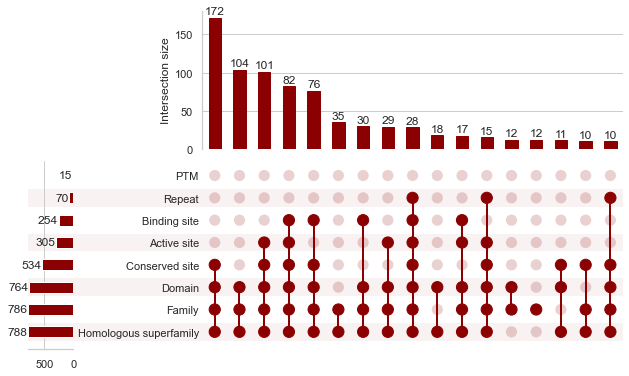

In [89]:
#Create UpSet-plot for inhibitors
up.UpSet(features_by_type_inhs, show_counts=True, sort_by='cardinality', min_subset_size=10, facecolor='darkred').plot()

### Plot histograms of number of interactions/features associated with each feature/interaction

In [34]:
def plot_histogram_features(type, aspect, mode=None, count_limit=0):
    #Specify which group of interactions should be plotted (activators, inhibitors, all)
    df = pd.DataFrame
    if mode == '+':
        df = dfs_acts
    elif mode == '-':
        df = dfs_inhs
    else:
        df = dfs

    #Find statistically significant assocations
    df_significant = df[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['features'])['interaction'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['interaction'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='features', y='Count', kind='bar', aspect=aspect, palette='crest')
    h.set_xticklabels(rotation=90)
    h.set_xlabels(f'{type.replace("_", " ")} (InterPro id)')
    h.set_ylabels('Number of interactions')
    plt.text(0.85, 0.85, f'Mode: {mode}\nCount limit: {count_limit} ', fontsize=15, transform=plt.gca().transAxes)


In [31]:
def plot_histogram_interactions(type, aspect, mode=None, count_limit=0):
    #Specify which group of interactions should be plotted (activators, inhibitors, all)
    df = pd.DataFrame
    if mode == '+':
        df = dfs_acts
    elif mode == '-':
        df = dfs_inhs
    else:
        df = dfs
        
    #Find statistically significant assocations
    df_significant = df[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['interaction(met)'])['features'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['features'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='interaction(met)', y='Count', kind='bar', aspect=aspect, palette='flare')
    h.set_xticklabels(rotation=90)
    h.set_xlabels('Interaction')
    if type == "Family" or type == "Homologous_superfamily":
        h.set_ylabels(f'Number of {type.replace("_", " ").replace("y", "").lower()}ies')
    else:
        h.set_ylabels(f'Number of {type.replace("_", " ").lower()}s')
    plt.text(0.85, 0.85, f'Mode: {mode}\nCount limit: {count_limit} ', fontsize=15, transform=plt.gca().transAxes)
   


##### Active sites

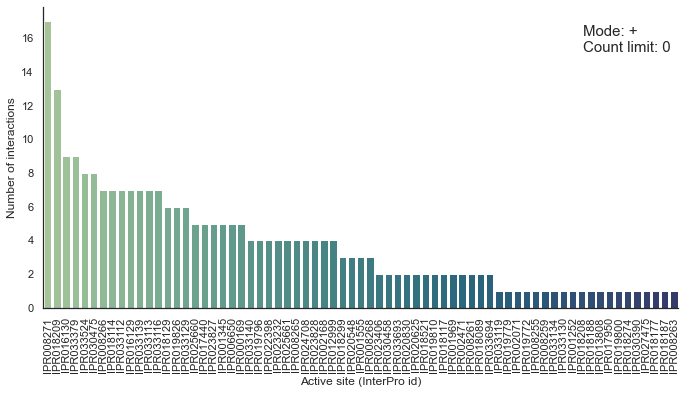

In [35]:
#Plot histogram of number of interactions associated with each active site for activators
plot_histogram_features(type='Active_site', mode = '+', aspect=2)

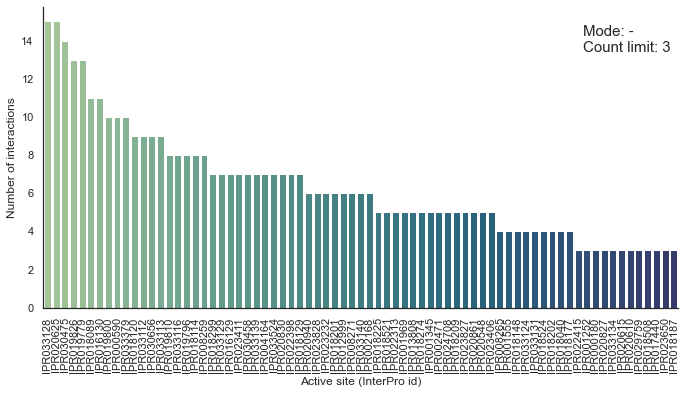

In [36]:
#Plot histogram of number of interactions associated with each active site for inhibitors
plot_histogram_features(type='Active_site', mode = '-', aspect=2, count_limit=3)

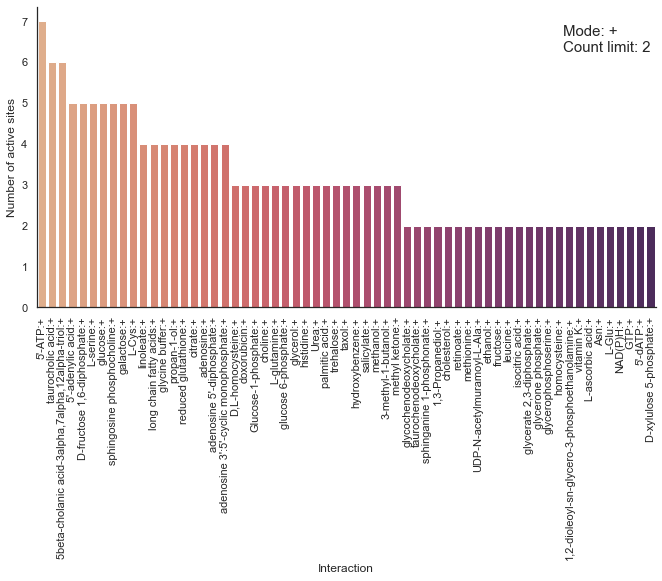

In [37]:
#Plot histogram of number of active sites associated with each interaction for activators
plot_histogram_interactions(type='Active_site', aspect=2.2, mode='+', count_limit=2)

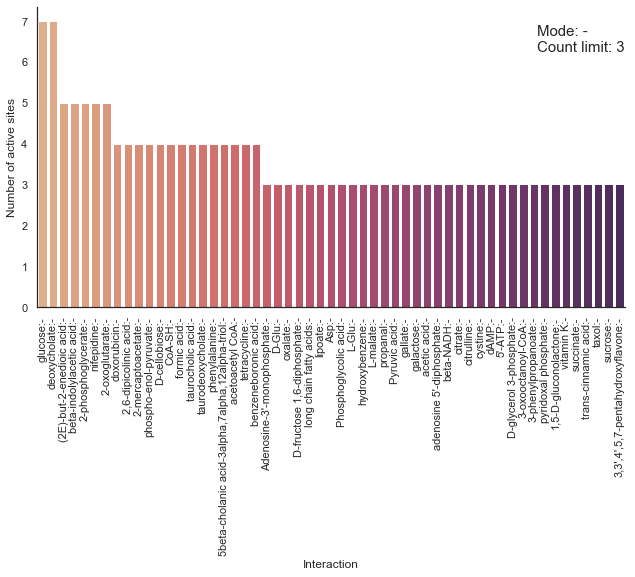

In [38]:
#Plot histogram of number of active sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Active_site', aspect=2, mode='-', count_limit=3)

#### Binding sites

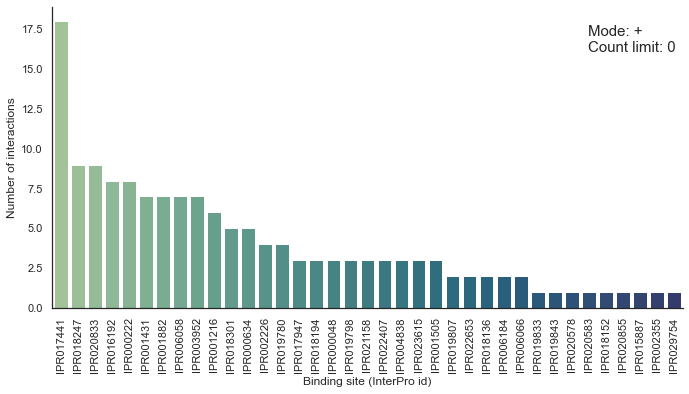

In [39]:
#Plot histogram of number of interactions associated with each binding site for activators
plot_histogram_features(type='Binding_site', aspect=2, mode= '+')

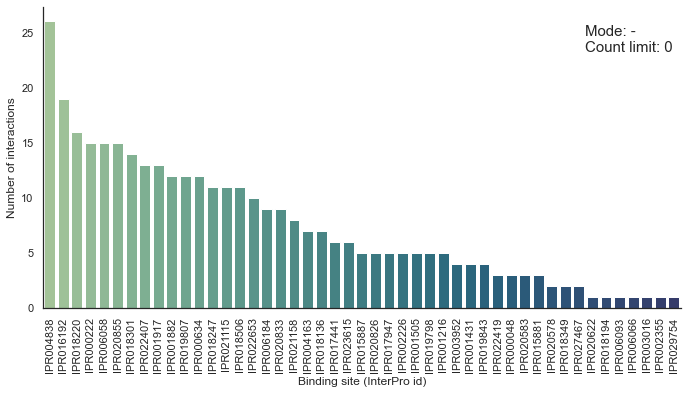

In [40]:
#Plot histogram of number of interactions associated with each binding site for inhibitors
plot_histogram_features(type='Binding_site', aspect=2, mode= '-')

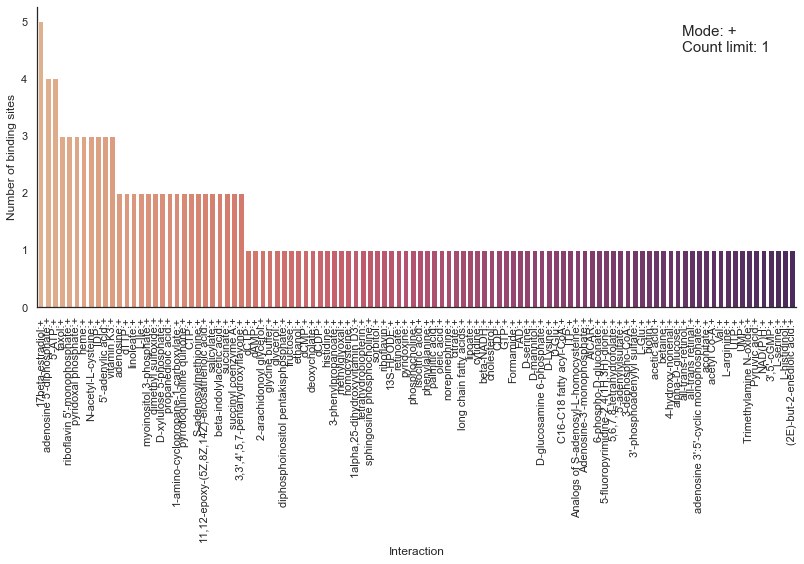

In [41]:
#Plot histogram of number of binding sites associated with each interaction for activators
plot_histogram_interactions(type='Binding_site', aspect=2.5, mode='+', count_limit=1)

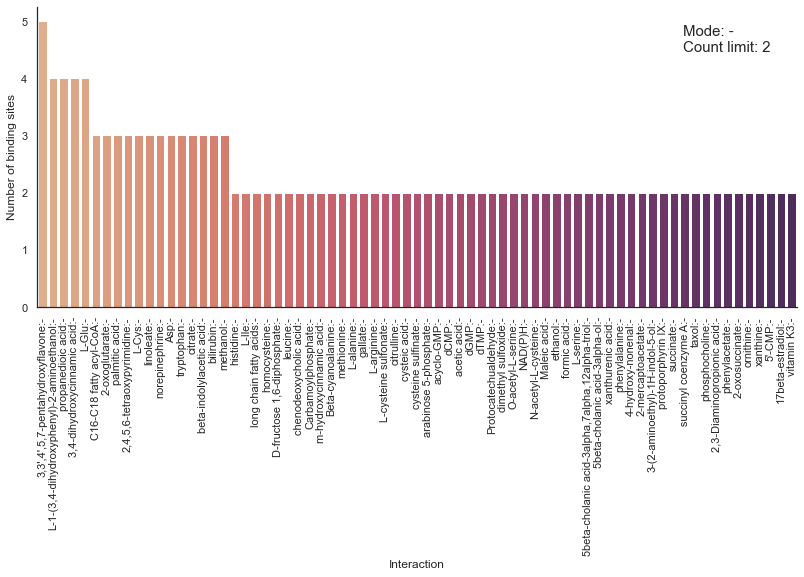

In [42]:
#Plot histogram of number of binding sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Binding_site', aspect=2.5, mode='-', count_limit=2)

#### Conserved sites

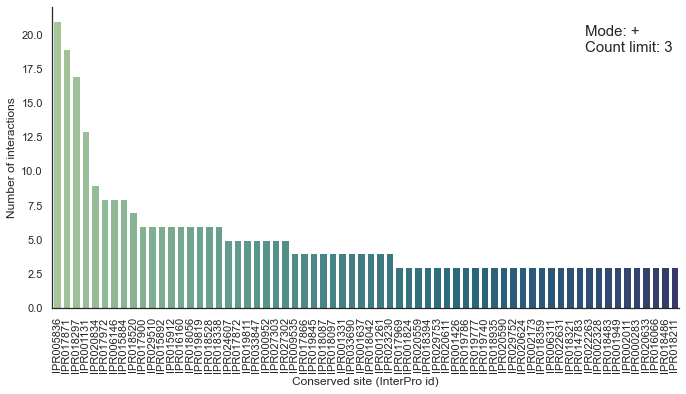

In [43]:
#Plot histogram of number of interactions associated with each conserved site for activators
plot_histogram_features(type='Conserved_site', aspect=2, mode='+', count_limit=3)

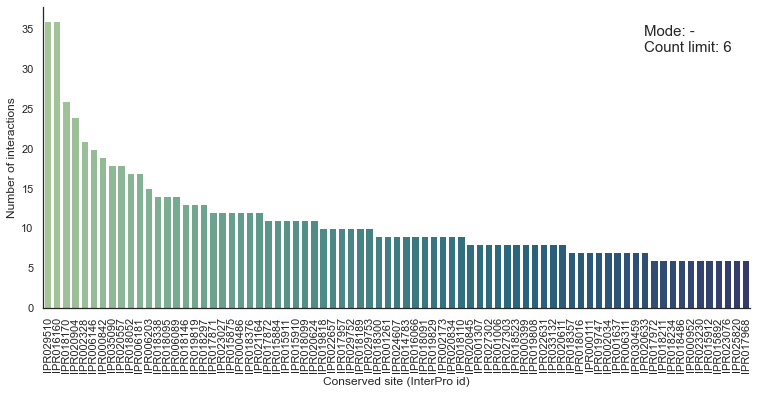

In [44]:
#Plot histogram of number of interactions associated with each conserved site for inhibitors
plot_histogram_features(type='Conserved_site', aspect=2.2, mode='-', count_limit=6)

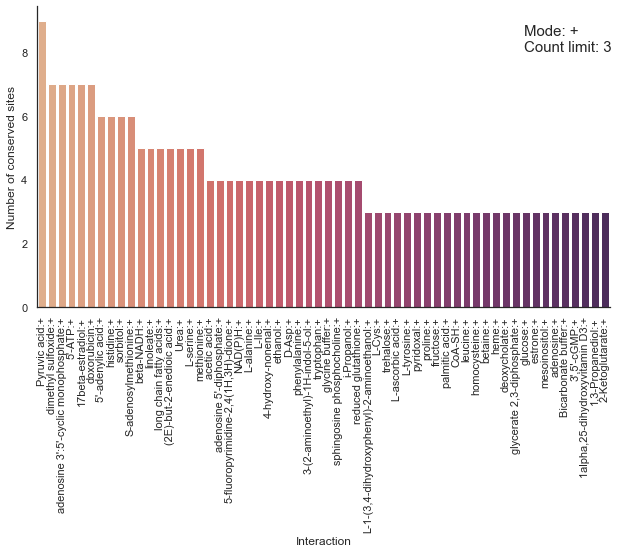

In [45]:
#Plot histogram of number of conserved sites associated with each interaction for activators
plot_histogram_interactions(type='Conserved_site', aspect=2, mode = '+', count_limit=3)

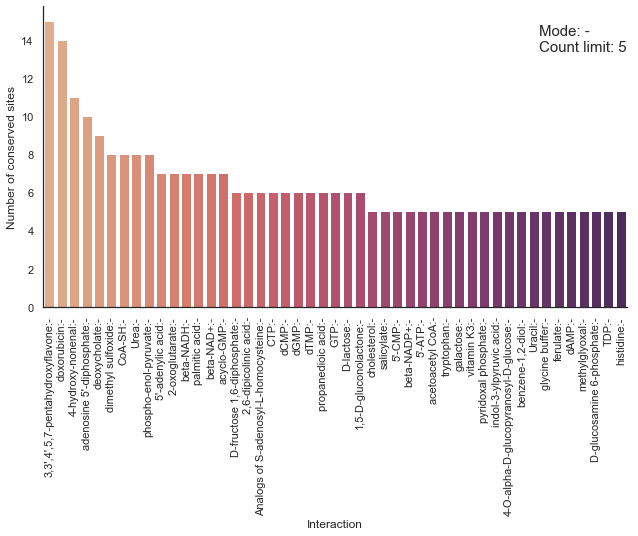

In [46]:
#Plot histogram of number of conserved sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Conserved_site', aspect=2, mode = '-', count_limit=5)

#### Domains

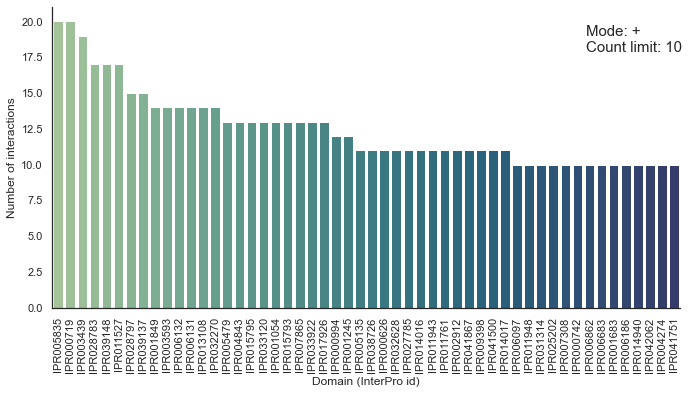

In [47]:
#Plot histogram of number of interactions associated with each domain for activators
plot_histogram_features(type='Domain', aspect=2, mode = '+', count_limit=10)

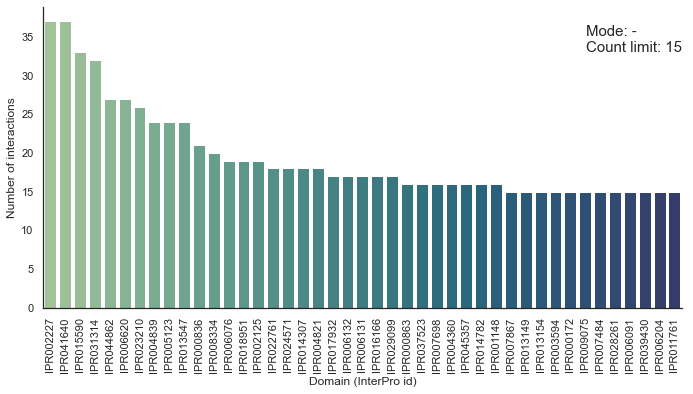

In [48]:
#Plot histogram of number of interactions associated with each domain for inhibitors
plot_histogram_features(type='Domain', aspect=2, mode = '-', count_limit=15)

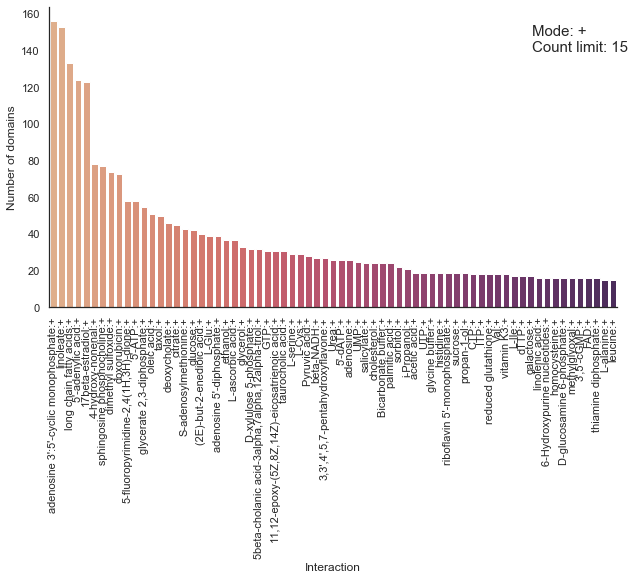

In [49]:
#Plot histogram of number of domains associated with each interaction for activators
plot_histogram_interactions(type='Domain', aspect=2, mode='+', count_limit=15)

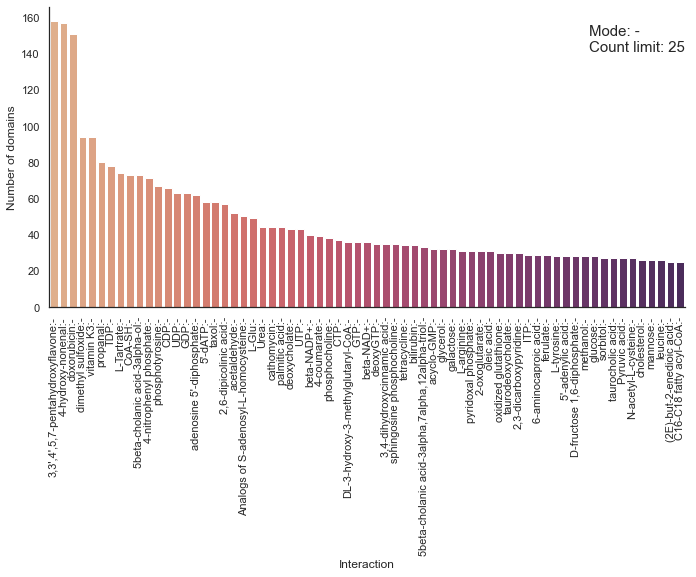

In [50]:
#Plot histogram of number of domains associated with each interaction for inhibitors
plot_histogram_interactions(type='Domain', aspect=2.2, mode='-', count_limit=25)

#### Families

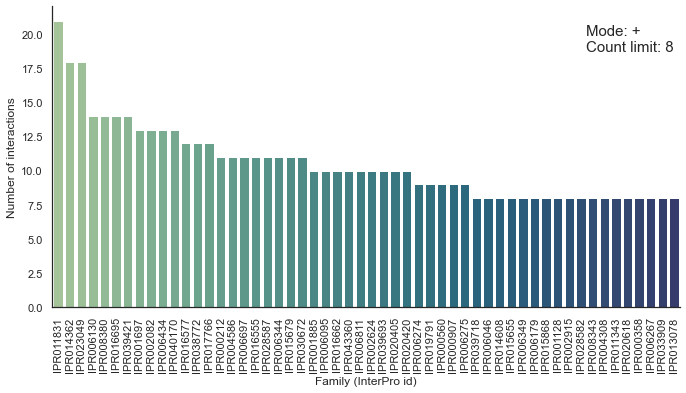

In [51]:
#Plot histogram of number of interactions associated with each family for activators
plot_histogram_features(type='Family', aspect=2, mode='+', count_limit=8)

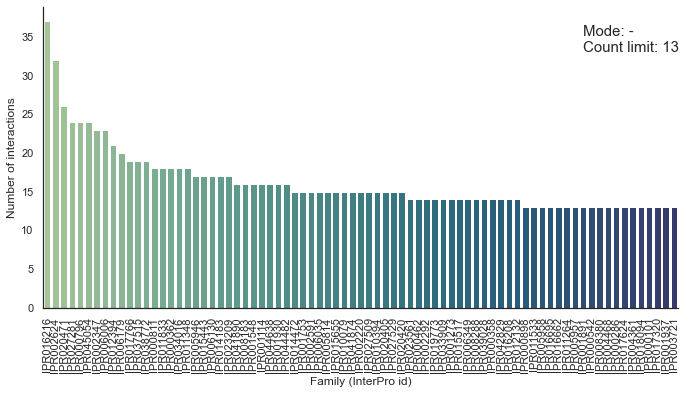

In [52]:
#Plot histogram of number of interactions associated with each family for inhibitors
plot_histogram_features(type='Family', aspect=2, mode='-', count_limit=13)

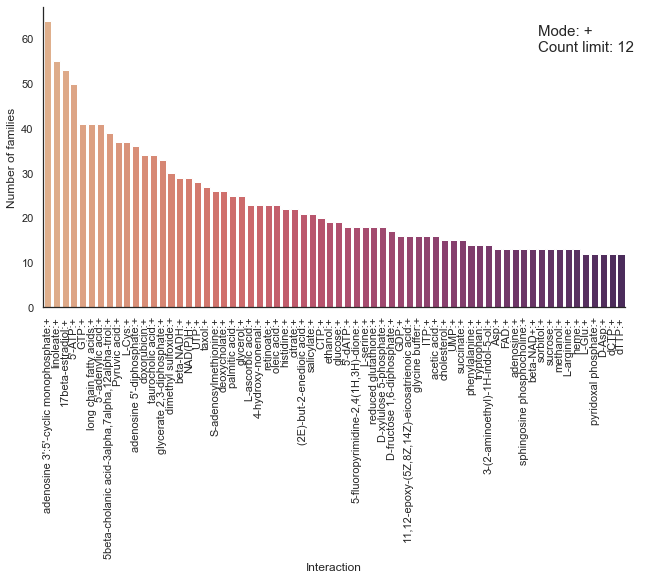

In [53]:
#Plot histogram of number of families associated with each interaction for activators
plot_histogram_interactions(type='Family', aspect=2, mode = '+', count_limit=12)

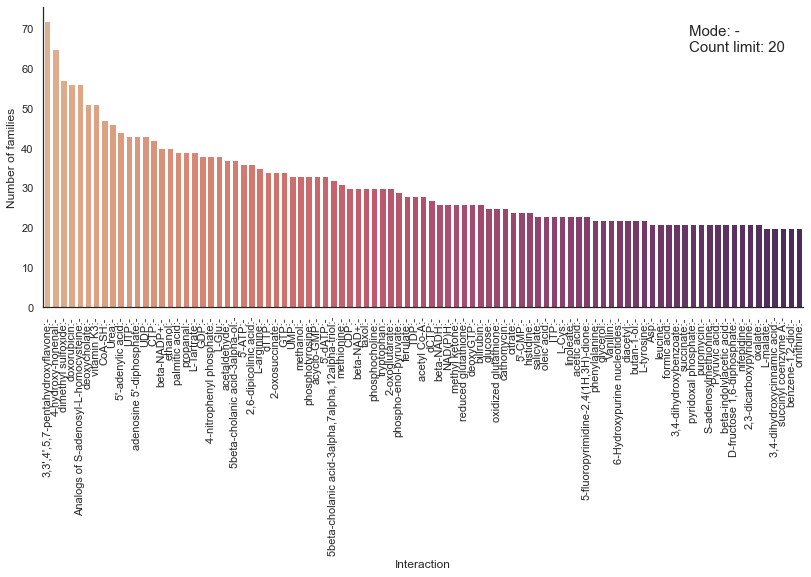

In [54]:
#Plot histogram of number of domains associated with each interaction for inhibitors
plot_histogram_interactions(type='Family', aspect=2.5, mode = '-', count_limit=20)

#### Homologous superfamilies

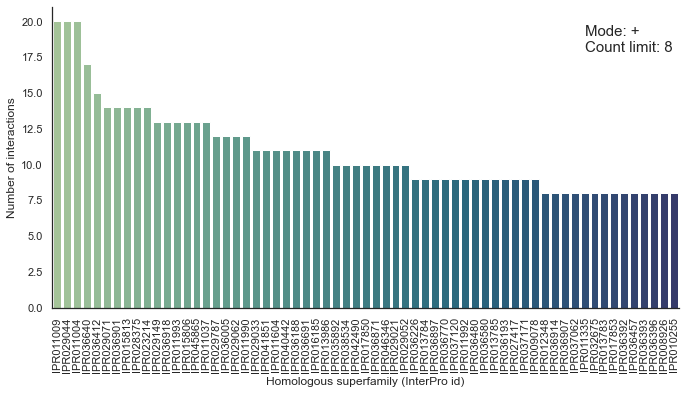

In [55]:
#Plot histogram of number of interactions associated with each homologous superfamily for activators
plot_histogram_features(type='Homologous_superfamily', aspect=2, mode = '+', count_limit=8)

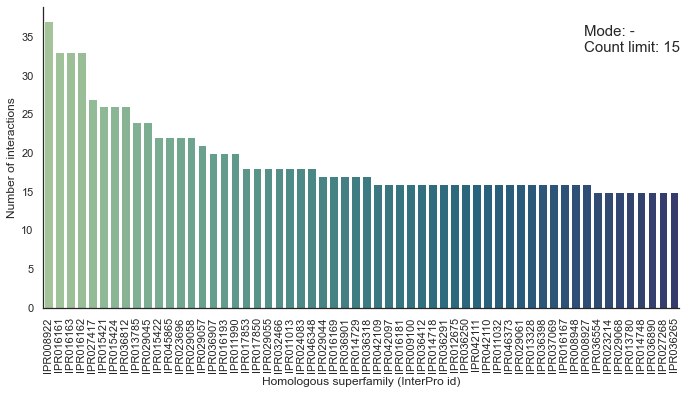

In [56]:
#Plot histogram of number of interactions associated with each homologous superfamily for inhibitors
plot_histogram_features(type='Homologous_superfamily', aspect=2, mode = '-', count_limit=15)

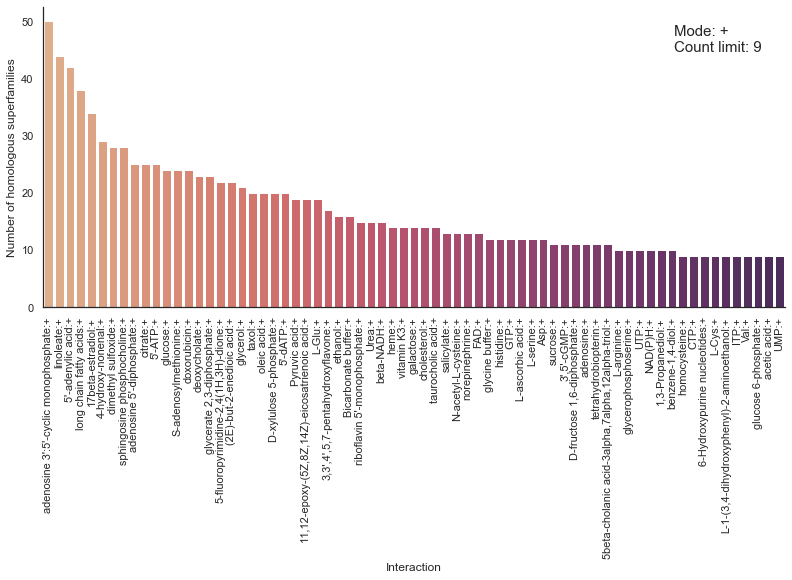

In [57]:
#Plot histogram of number of homologous superfamilies  associated with each interaction for activators
plot_histogram_interactions(type='Homologous_superfamily', aspect=2.5, mode = '+', count_limit=9)

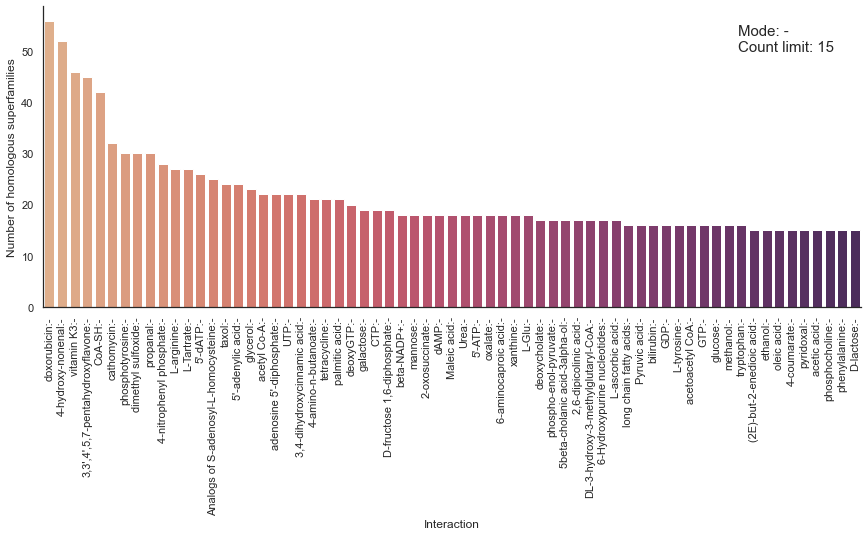

In [58]:
#Plot histogram of number of homologous superfamilies  associated with each interaction for inhibitors
plot_histogram_interactions(type='Homologous_superfamily', aspect=2.5, mode = '-', count_limit=15)

#### PTMs

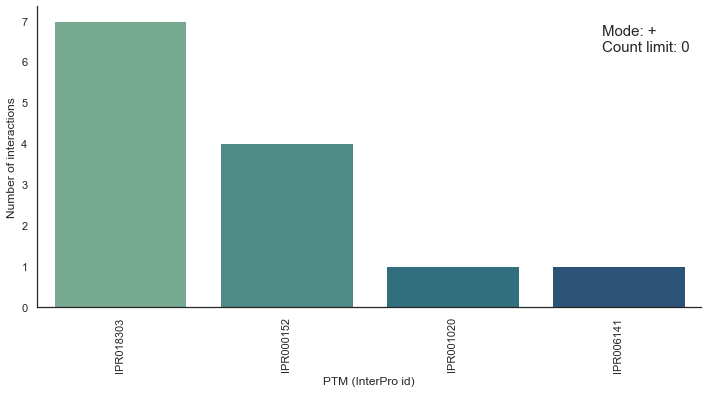

In [59]:
#Plot histogram of number of interactions associated with each PTM for activators
plot_histogram_features(type='PTM', mode = '+', aspect=2)

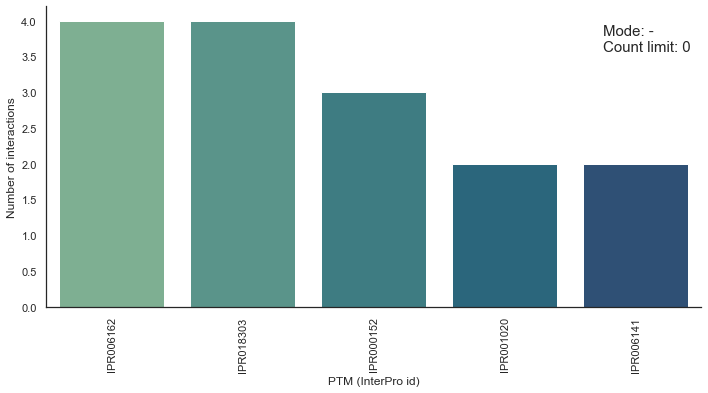

In [60]:
#Plot histogram of number of interactions associated with each PTM for inhibitors
plot_histogram_features(type='PTM', aspect=2, mode='-')

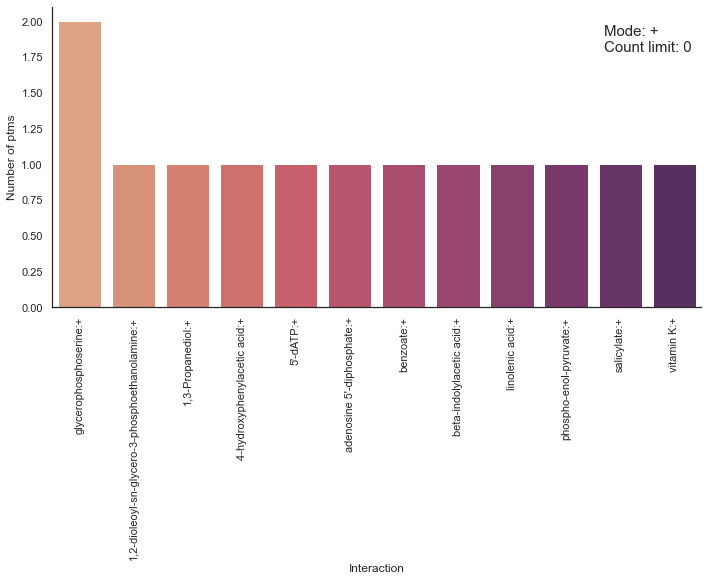

In [61]:
#Plot histogram of number of PTMs associated with each interaction for activators
plot_histogram_interactions(type='PTM', aspect=2, mode='+')

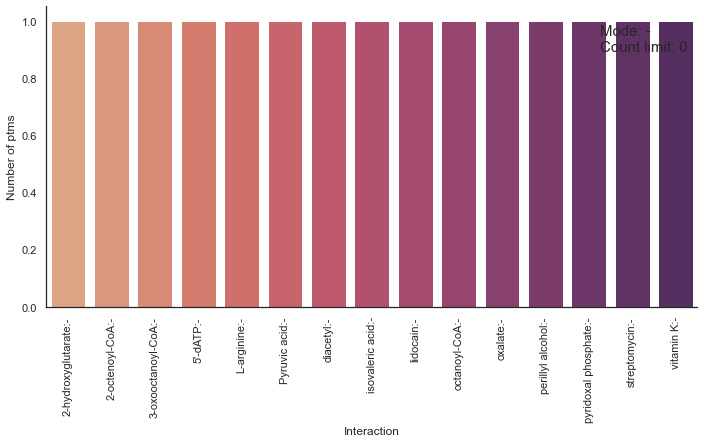

In [62]:
#Plot histogram of number of PTMs associated with each interaction for inhibitors
plot_histogram_interactions(type='PTM', aspect=2, mode='-')

#### Repeats

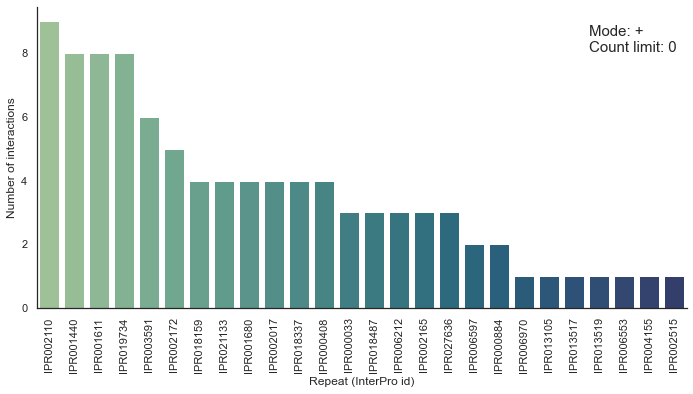

In [64]:
#Plot histogram of number of interactions associated with each repeat for activators
plot_histogram_features(type='Repeat', aspect=2, mode='+')

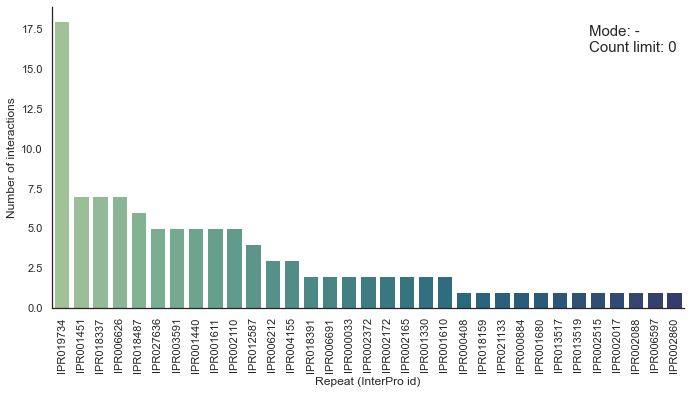

In [65]:
#Plot histogram of number of interactions associated with each repeat for inhibitors
plot_histogram_features(type='Repeat', aspect=2, mode='-')

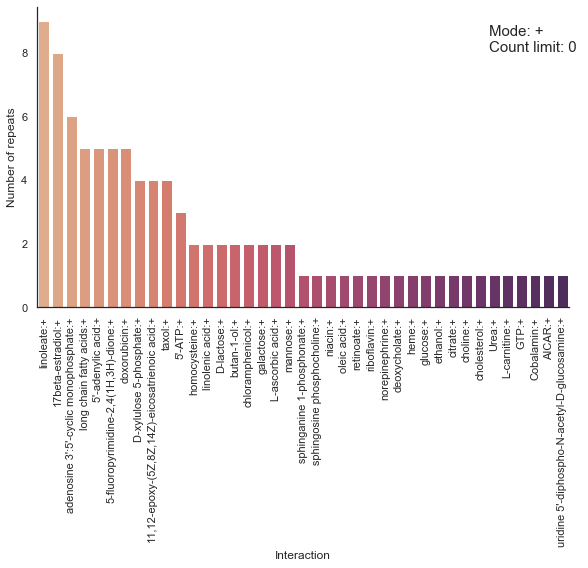

In [66]:
#Plot histogram of number of repeats associated with each interaction for activators
plot_histogram_interactions(type='Repeat', aspect=2, mode='+')

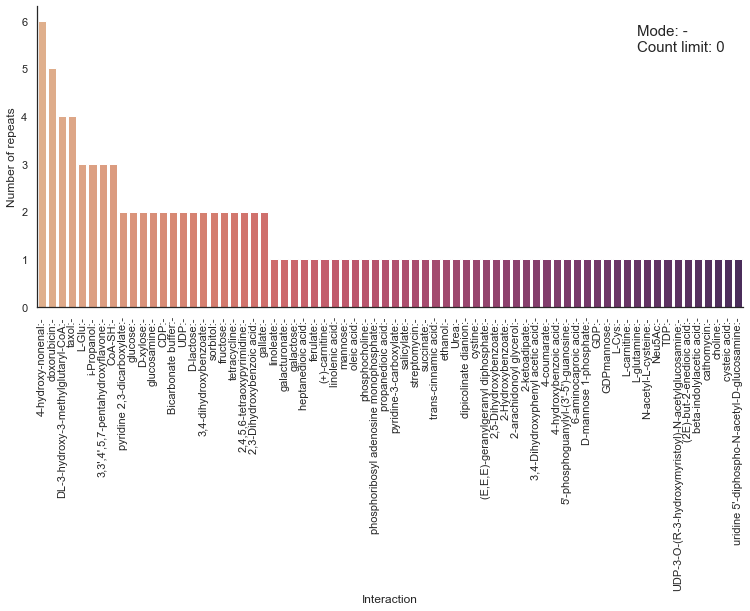

In [67]:
#Plot histogram of number of repeats associated with each interaction for inhibitors
plot_histogram_interactions(type='Repeat', aspect=2.5, mode='-')